# pm2.5 time series

In [1]:
import json
import datetime as dt
import pytz
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics

from fbprophet import Prophet

from statsmodels.tsa.api import ExponentialSmoothing

import statsmodels.api as sm
# Augmented Dickey-Fuller (ADF) test 
from statsmodels.tsa.stattools import adfuller
# Decompose trend, seasonality & residual
from statsmodels.tsa.seasonal import seasonal_decompose
# ACF and PACF
from statsmodels.tsa.stattools import acf, pacf
# ARIMA 
from statsmodels.tsa.arima_model import ARIMA

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


## Functions that get data from server to us

In [2]:
def get_data_by_pos(pos):
    r = requests.get(f'http://140.116.82.93:6800/campus/display/{ pos }')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

In [3]:
def get_all_data():
    r = requests.get(f'http://140.116.82.93:6800/training')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

## Prophet

In [4]:
# Load data
pos = 3
data3 = get_data_by_pos(pos)
df3 = pd.DataFrame(data3)
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Data cleaning
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()
df3mean.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [5]:
# Create another df for fitting model
df_4_fit = pd.DataFrame(columns=['ds_tz','y'])
df_4_fit['ds_tz'] = df3mean['time']
df_4_fit['y'] = df3mean['pm2.5'].values

In [6]:
# Divid training set and test set
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)

train_prophet = df_4_fit[:four_fifth_len]
test_prophet = df_4_fit[four_fifth_len:]

In [7]:
# Discard timezone info
train_prophet['ds'] = train_prophet['ds_tz'].values
test_prophet['ds'] = test_prophet['ds_tz'].values

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
# Fit the model
prophet = Prophet(yearly_seasonality=False)
prophet.fit(train_prophet)

In [9]:
# 未來要預測的頻率（天、週….）與長度需要先用make_future_dataframe定義好，再利用模型預測數值
future = prophet.make_future_dataframe(freq = 'H', periods=len(test_prophet))

In [10]:
# Predict
forecast = prophet.predict(future)

In [11]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2327,2019-08-21 23:54:00,17.823827,5.114119,29.728149
2328,2019-08-22 00:54:00,17.251069,4.333187,28.524816
2329,2019-08-22 01:54:00,16.366414,3.780845,28.349732
2330,2019-08-22 02:54:00,15.275998,3.171328,26.769882
2331,2019-08-22 03:54:00,14.189084,2.532825,26.500818


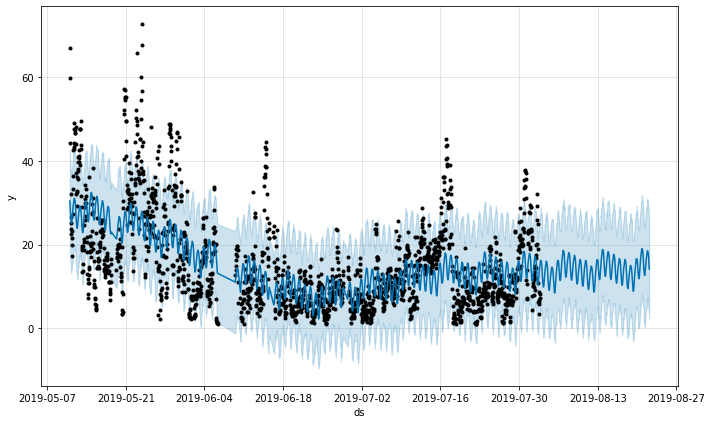

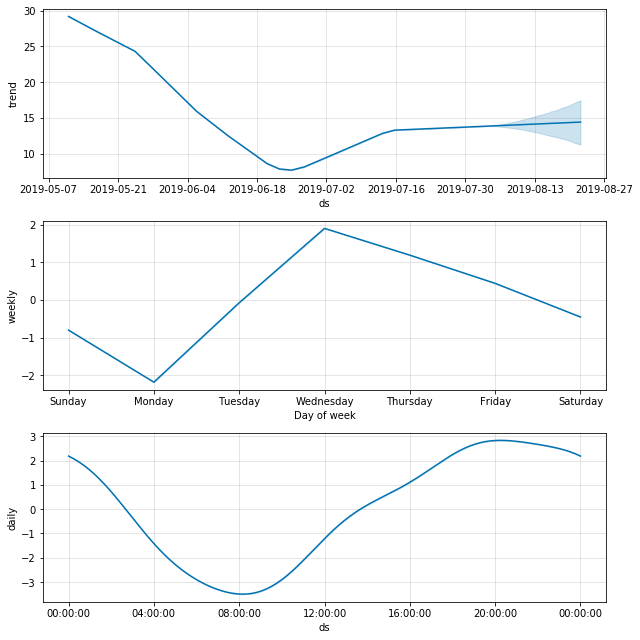

In [12]:
# 內建繪圖
prophet.plot(forecast)
prophet.plot_components(forecast);

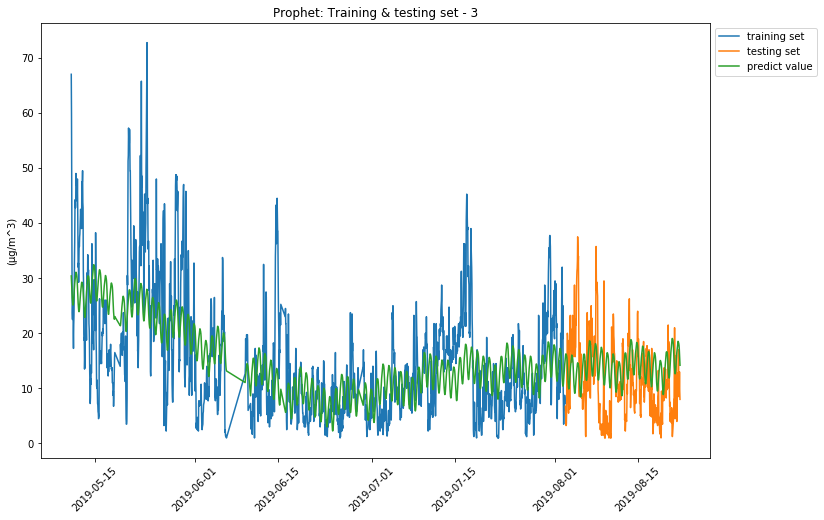

In [13]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 8))
# plt.style.use('ggplot')
plt.plot(train_prophet['ds'], train_prophet['y'], label='training set')
plt.plot(test_prophet['ds'], test_prophet['y'], label='testing set')
plt.plot(forecast['ds'], forecast['yhat'], label='predict value')
plt.xticks(rotation=45)
plt.ylabel('(μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Prophet: Training & testing set - %d' % pos)
plt.show()

In [14]:
predict_y = forecast[['ds', 'yhat']]

In [15]:
# Add timezone
test_prophet['ds'] = test_prophet['ds'].apply(lambda x: x.tz_localize('UTC'))
test_prophet['ds'] = test_prophet['ds'].apply(lambda x: x.astimezone(pytz.timezone('Asia/Taipei')))
predict_y['ds'] = predict_y['ds'].apply(lambda x: x.tz_localize('UTC'))
predict_y['ds'] = predict_y['ds'].apply(lambda x: x.astimezone(pytz.timezone('Asia/Taipei')))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [16]:
# Select the testing set part
predict_y = predict_y[four_fifth_len:]

In [17]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mse = metrics.mean_squared_error(test_prophet['y'], predict_y['yhat'])

test_mape = mean_absolute_percentage_error(test_prophet['y'], predict_y['yhat'])

print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Test MSE:	 64.610430,	 RMSE: 8.038061 (μg/m^3),	 MAPE:	 138.542884 %


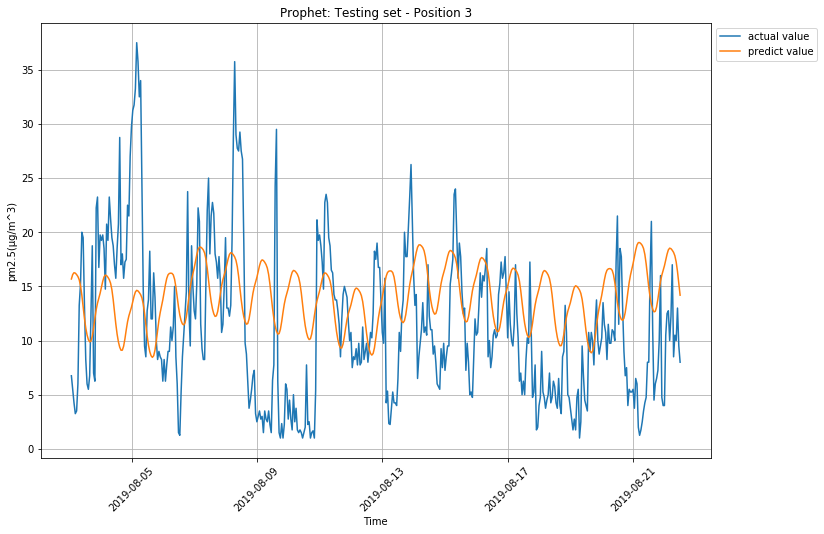

In [18]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 8))
# plt.style.use('ggplot')
plt.plot(test_prophet['ds'], test_prophet['y'], label='actual value')
plt.plot(predict_y['ds'], predict_y['yhat'], label='predict value')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('pm2.5(μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Prophet: Testing set - Position %d' % pos)
plt.grid()
plt.show()

## Holt-Winters' Method

In [19]:
# Load data
pos = 3
data3 = get_data_by_pos(pos)
df3 = pd.DataFrame(data3)
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Data cleaning
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()
df3mean.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [20]:
# Divid training set and test set
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)
train_df = df3mean[:four_fifth_len]
test_df = df3mean[four_fifth_len:]

In [21]:
# Fit the model
Holt_Winters_model = ExponentialSmoothing(np.asarray(train_df['pm2.5']), 
                                          seasonal_periods=24, 
                                          trend='add', 
                                          seasonal='add', 
                                          damped=True).fit()
# Predict
predict_y = Holt_Winters_model.forecast(len(test_df))

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [22]:
# Calculate MSE, MAPE for training set & test set

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mse = metrics.mean_squared_error(test_df['pm2.5'], predict_y)

test_mape = mean_absolute_percentage_error(test_df['pm2.5'], predict_y)

print('Test MSE:\t %f,\t RMSE: %f (μg/m^3),\t MAPE:\t %f %%' % (test_mse, np.sqrt(test_mse), test_mape))

Test MSE:	 62.819790,	 RMSE: 7.925894 (μg/m^3),	 MAPE:	 87.398029 %


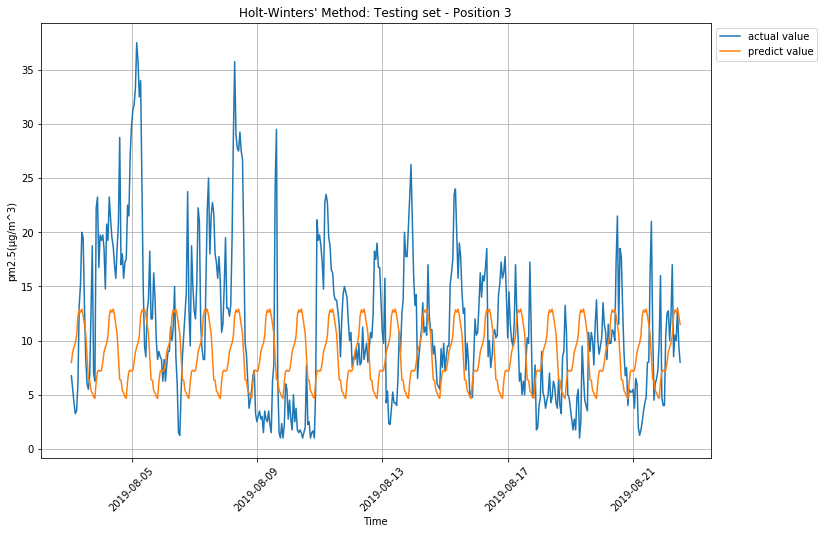

In [23]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()
# Plt
plt.figure(figsize=(12, 8))
# plt.style.use('ggplot')
plt.plot(test_df['time'], test_df['pm2.5'], label='actual value')
plt.plot(test_df['time'], predict_y, label='predict value')
plt.xticks(rotation=45)
plt.xlabel('Time')
plt.ylabel('pm2.5(μg/m^3)')
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.title('Holt-Winters\' Method: Testing set - Position %d' % pos)
plt.grid()
plt.show()

## ARIMA

In [24]:
# Load data
pos = 3
data3 = get_data_by_pos(3)
df3 = pd.DataFrame(data3)
# Input time
if pos == 2:
    time = ['2019 06 06', '2020 01 01']
else:
    time = ['2019 05 11', '2020 01 01']
time = ['2019 05 11', '2020 01 01']
taipei_tz = pytz.timezone('Asia/Taipei')
# Set time
start_time = dt.datetime.strptime(time[0], '%Y %m %d').replace(tzinfo=taipei_tz)
end_time = dt.datetime.strptime(time[1], '%Y %m %d').replace(tzinfo=taipei_tz)
# Select the duration
df3 = df3.loc[ df3['date'] >= start_time ]
df3 = df3.loc[ df3['date'] <= end_time ]
# Rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})
# Data cleaning
df3 = df3.loc[ df3['pm2.5'] <= 120 ]
df3 = df3.loc[ df3['humidity'] <= 100 ]
# Split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)
# Set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
# Evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()
df3mean.reset_index(inplace=True)
# Reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [25]:
# Divid training set and test set
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)
train_df = df3mean[:four_fifth_len]
test_df = df3mean[four_fifth_len:]

In [26]:
df3mean['time_values'] = df3mean['time'].values
ts = df3mean[['time_values', 'pm2.5']].set_index('time_values')

In [27]:
# Define a function to test if our data is stationary
# Use a method called Augmented Dickey-Fuller (ADF) test 

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    # Add explicitly converter
    pd.plotting.register_matplotlib_converters()
    # Plot rolling statistics:
    plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, label='Original')
    mean = plt.plot(rolmean, label='Rolling Mean')
    std = plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

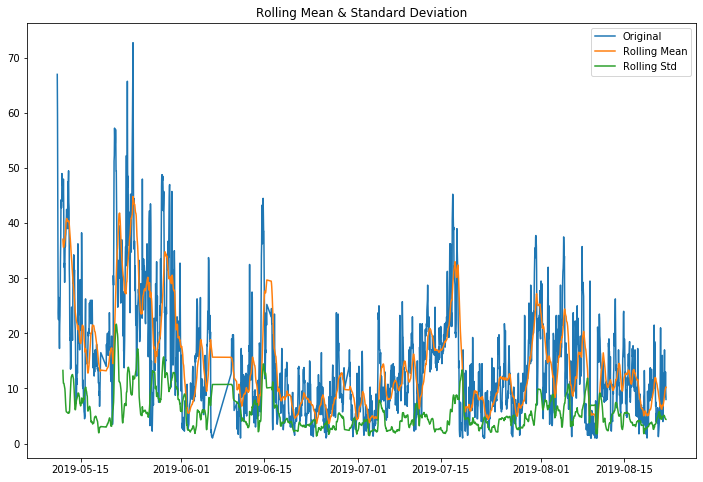

Results of Dickey-Fuller Test:
Test Statistic                   -4.802411
p-value                           0.000054
#Lags Used                       18.000000
Number of Observations Used    2313.000000
Critical Value (1%)              -3.433180
Critical Value (5%)              -2.862790
Critical Value (10%)             -2.567436
dtype: float64


In [28]:
test_stationarity(ts)

### Try to Eliminate Trend & Seasonality

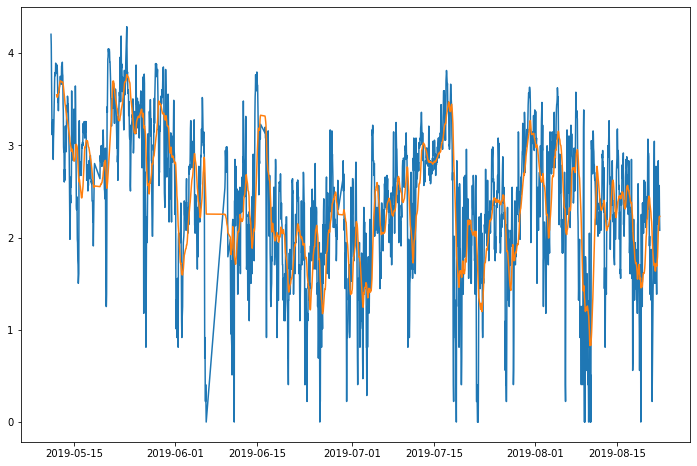

In [29]:
# Calculate log(ts) & its moving average
ts_log = np.log(ts)
moving_avg = ts_log.rolling(24).mean()

plt.figure(figsize=(12, 8))
plt.plot(ts_log)
plt.plot(moving_avg)

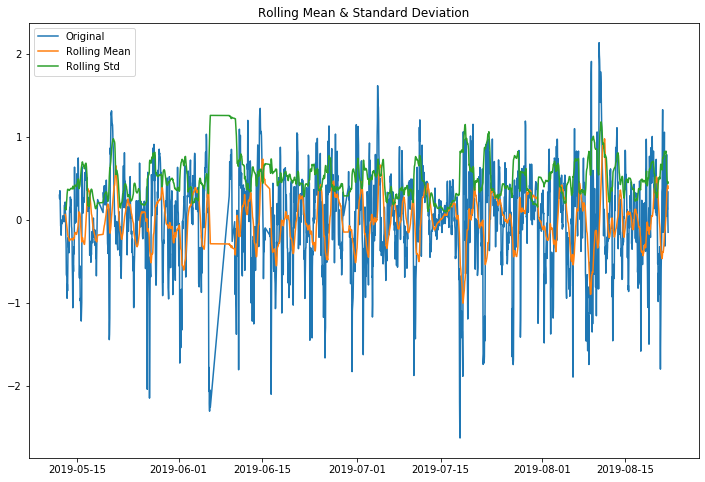

Results of Dickey-Fuller Test:
Test Statistic                -1.379850e+01
p-value                        8.659208e-26
#Lags Used                     1.100000e+01
Number of Observations Used    2.297000e+03
Critical Value (1%)           -3.433200e+00
Critical Value (5%)           -2.862799e+00
Critical Value (10%)          -2.567440e+00
dtype: float64


In [30]:
# Calculate log(ts) subtract the moving avg of log(ts)
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

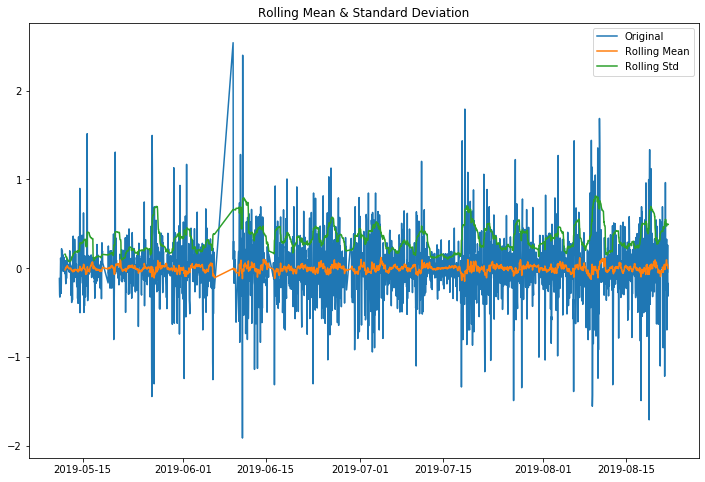

Results of Dickey-Fuller Test:
Test Statistic                -1.622268e+01
p-value                        3.883335e-29
#Lags Used                     2.000000e+01
Number of Observations Used    2.310000e+03
Critical Value (1%)           -3.433184e+00
Critical Value (5%)           -2.862792e+00
Critical Value (10%)          -2.567437e+00
dtype: float64


In [31]:
# Calculate the first-order difference
ts_log_diff = ts_log - ts_log.shift()

ts_log_diff.dropna(inplace=True)

test_stationarity(ts_log_diff)

In [ ]:
# Decompose trend, seasonality & residual
decomposition = seasonal_decompose(ts_log_diff)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
# Check the stability of residual
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

* 在AR(p)模型中，ACF為指數遞減，PACF為在p期截斷。
* 在MA(q)模型中，PACF為為指數遞減，ACF為q期截斷。

In [ ]:
# ACF and PACF plots
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

In [ ]:
plt.figure(figsize=(12, 5))
# Plot ACF
plt.subplot(121) 
plt.plot(lag_acf, marker='.')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf, marker='.')
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [ ]:
# Fit the model
model = ARIMA(ts_log_diff, order=(2, 1, 2), freq='H')  
results_ARIMA = model.fit(disp=-1)  
plt.figure(figsize=(12, 8))
plt.plot(ts_log_diff, label='actual')
plt.plot(-results_ARIMA.fittedvalues, label='predict')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.legend()
plt.show()

In [ ]:
# Fit the model
arima_model = sm.tsa.statespace.SARIMAX(train_df['pm2.5'], 
                                        order=(2, 1, 2),
                                        seasonal_order=(0,1,1,7)).fit()

In [ ]:
# Predict
predict_y = arima_model.predict(start='2019-07-31 15:54:00', 
                                end='2019-08-09 14:54:00', 
                                dynamic=True)